In [8]:
import pandas as pd
import pandas_profiling
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_precision_recall_curve, precision_recall_curve, PrecisionRecallDisplay


In [10]:
data = pd.read_csv("data/corona_tested_individuals_ver_00220_eng.csv")

<ipython-input-10-9195f0d75244>:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("corona_tested_individuals_ver_00220.english.csv")


In [11]:
# take a look at the data
data.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2022-01-30,0,0,0,0,0,positive,No,female,Other
1,2022-01-30,0,0,0,0,0,positive,No,female,Other
2,2022-01-30,0,0,0,0,0,positive,No,male,Other
3,2022-01-30,0,0,0,0,0,positive,No,female,Other
4,2022-01-30,0,0,0,0,0,positive,No,female,Other


In [12]:
data.info() # need to turn into numeric variables and change date into datetime variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8890301 entries, 0 to 8890300
Data columns (total 10 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   test_date            object
 1   cough                int64 
 2   fever                int64 
 3   sore_throat          int64 
 4   shortness_of_breath  int64 
 5   head_ache            int64 
 6   corona_result        object
 7   age_60_and_above     object
 8   gender               object
 9   test_indication      object
dtypes: int64(5), object(5)
memory usage: 678.3+ MB


Check NAs, and remove for now.

In [13]:
data.isna().sum() # count the number of NAs and where within the dataset

test_date                    0
cough                        0
fever                        0
sore_throat                  0
shortness_of_breath          0
head_ache                    0
corona_result                0
age_60_and_above       2029966
gender                  663908
test_indication              0
dtype: int64

Dropping NAs from data

In [14]:
# keep a copy of the raw data for reference
data_raw = data.copy()
data = data.dropna()

In [15]:
#Removing other class from the target feature
mask = data["corona_result"] != "other"
data = data[mask]

Dropping NAs for now as these are to do with demographic values, and Age was only introduced later into the collection process. Come back for imputation and gradient boosting.


1.   corona_results_positive: 1 - positive and 0 - negative
2.   List age_60_and_above: 1- True and 0 - False
3.   gender: 1- Male and 0 - Female
4.   test_indication: 1 - contact with confirmed
5.   test_indiction_other: 1 - other indication/not specified
6.   test_indication = 0 and test_indiction_other = 0: arrived from abroad



In [16]:
# change the objects to integers
data = pd.get_dummies(data = data, columns = ["corona_result", "age_60_and_above", "gender", "test_indication"], drop_first = True)

In [17]:
# change the date to datetime object
data.test_date = pd.to_datetime(data.test_date)

In [18]:
# look at the numeric range, etc.
data.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result_positive,age_60_and_above_Yes,gender_male,test_indication_Contact with confirmed,test_indication_Other
count,6.566878e+06,6.566878e+06,6.566878e+06,6.566878e+06,6.566878e+06,6.566878e+06,6.566878e+06,6.566878e+06,6.566878e+06,6.566878e+06
mean,5.011270e-02,3.980004e-02,2.007392e-02,4.360824e-03,4.108162e-02,1.146947e-01,1.293560e-01,4.851264e-01,8.802554e-02,9.072652e-01
std,2.181775e-01,1.954891e-01,1.402532e-01,6.589240e-02,1.984790e-01,3.186531e-01,3.355936e-01,4.997788e-01,2.833321e-01,2.900604e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [19]:
data = data.set_index('test_date')

In [20]:
#  see data folder for profile output
# sample = data.sample(100000)

# create profile
# profile = ProfileReport(sample, title="Profile of Israeli Dataset")
# profile.to_notebook_iframe()

Feature addition: adding our world in data information for Israel for top level information.

In [21]:
owid = pd.read_csv("data/owid-covid-data.csv")

In [22]:
owid_isr = owid[owid.iso_code == "ISR"]

Check for NAs and the data types which we will be using

In [23]:
owid_isr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 88874 to 89746
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    873 non-null    object 
 1   continent                                   873 non-null    object 
 2   location                                    873 non-null    object 
 3   date                                        873 non-null    object 
 4   total_cases                                 872 non-null    float64
 5   new_cases                                   869 non-null    float64
 6   new_cases_smoothed                          864 non-null    float64
 7   total_deaths                                844 non-null    float64
 8   new_deaths                                  837 non-null    float64
 9   new_deaths_smoothed                         829 non-null    float64
 10  total_ca

In [24]:
# drop ncolumns with manu NAs immadietly
cols_drop = {"handwashing_facilities", "excess_mortality_cumulative_absolute", 
             "excess_mortality_cumulative", "excess_mortality", 
             "excess_mortality_cumulative_per_million", "iso_code", "continent", "location"}
owid_isr_filt = owid_isr.drop(columns = cols_drop)

In [25]:
owid_isr_filt.date = pd.to_datetime(owid_isr_filt.date)

In [26]:
# filter to the time period of interest
owid_isr_filt = owid_isr_filt[(owid_isr_filt.date >= "2020-03-20 00:00:00") & (owid_isr_filt.date <= "2022-01-30 00:00:00")]

In [27]:
owid_isr_filt.head()

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index
88903,2020-03-20,628.0,242.0,73.714,1.0,1.0,NaN,67.592,26.047,7.934,...,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,2.99,82.97,0.919
88904,2020-03-21,843.0,215.0,100.714,1.0,0.0,NaN,90.733,23.141,10.840,...,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,2.99,82.97,0.919
88905,2020-03-22,1080.0,237.0,129.000,1.0,0.0,NaN,116.242,25.509,13.884,...,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,2.99,82.97,0.919
88906,2020-03-23,1249.0,169.0,142.571,1.0,0.0,NaN,134.431,18.190,15.345,...,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,2.99,82.97,0.919
88907,2020-03-24,1351.0,102.0,150.857,4.0,3.0,NaN,145.410,10.978,16.237,...,7.359,33132.32,0.5,93.32,6.74,15.4,35.4,2.99,82.97,0.919


Format and filter the owid data

In [28]:
owid_isr_filt = owid_isr_filt[['date','new_cases_smoothed_per_million', 'reproduction_rate', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million', 'people_vaccinated_per_hundred', 'stringency_index']]

In [29]:
owid_isr_filt.isna().sum()

date                                    0
new_cases_smoothed_per_million          2
reproduction_rate                       0
weekly_icu_admissions_per_million       0
weekly_hosp_admissions_per_million      0
people_vaccinated_per_hundred         274
stringency_index                        0
dtype: int64

In [30]:
owid_isr_filt['people_vaccinated_per_hundred'] = owid_isr_filt['people_vaccinated_per_hundred'].fillna(0)
owid_isr_filt['new_cases_smoothed_per_million'] = owid_isr_filt['new_cases_smoothed_per_million'].fillna(0)

In [31]:
owid_isr_filt.describe()

,new_cases_smoothed_per_million,reproduction_rate,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,people_vaccinated_per_hundred,stringency_index
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,416.780362,1.102639,5.622881,74.922553,34.149707,61.563871
std,1141.526429,0.457527,5.272175,72.270722,30.561319,16.671846
min,0.000000,0.410000,0.000000,1.830000,0.000000,22.220000
25%,39.785250,0.740000,0.888000,13.373000,0.000000,55.560000
50%,121.777000,1.040000,4.251500,54.084500,49.120000,59.260000
75%,396.178500,1.370000,8.799000,117.775000,63.217500,75.000000
max,10968.157000,2.950000,23.141000,399.957000,72.090000,94.440000


Plot time series of the # of death, # vacinations, stringecy, and hospitalisations

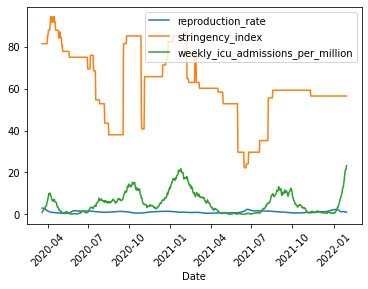

In [32]:
import matplotlib.pyplot as plt

plt.plot(owid_isr_filt.date, owid_isr_filt.reproduction_rate, label = "reproduction_rate")
plt.plot(owid_isr_filt.date, owid_isr_filt.stringency_index, label = "stringency_index")
plt.plot(owid_isr_filt.date, owid_isr_filt.weekly_icu_admissions_per_million, label = "weekly_icu_admissions_per_million")
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

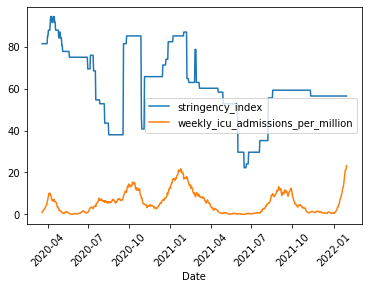

In [33]:
plt.plot(owid_isr_filt.date, owid_isr_filt.stringency_index, label = "stringency_index")
plt.plot(owid_isr_filt.date, owid_isr_filt.weekly_icu_admissions_per_million, label = "weekly_icu_admissions_per_million")
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

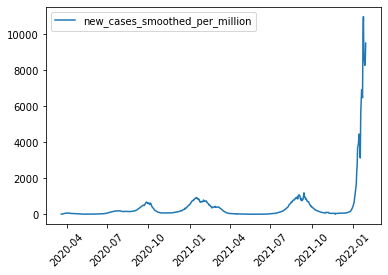

In [34]:
plt.plot(owid_isr_filt.date, owid_isr_filt.new_cases_smoothed_per_million, label = "new_cases_smoothed_per_million")
plt.xticks(rotation=45)
plt.legend()
plt.show()

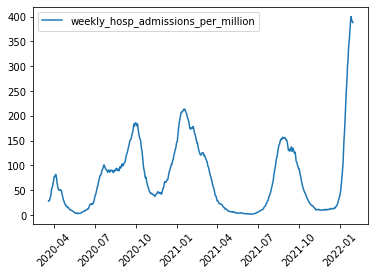

In [35]:
plt.plot(owid_isr_filt.date, owid_isr_filt.weekly_hosp_admissions_per_million, label = "weekly_hosp_admissions_per_million")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [37]:
owid_isr_filt = owid_isr_filt.set_index('date')

In [38]:
#lagged as it is reactive and therefore assigning the stringency closer to the time of infection/contagion rather than test date
owid_isr_filt["stringency_index_lagged"] = owid_isr_filt.shift(7, axis = 0).stringency_index
owid_isr_filt["new_cases_smoothed_per_million_lag"] = owid_isr_filt.shift(7, axis = 0).new_cases_smoothed_per_million
owid_isr_filt["reproduction_rate_lag"] = owid_isr_filt.shift(7, axis = 0).reproduction_rate
owid_isr_filt["weekly_icu_admissions_per_million_lag"] = owid_isr_filt.shift(7, axis = 0).weekly_icu_admissions_per_million
owid_isr_filt["weekly_hosp_admissions_per_million_lag"] = owid_isr_filt.shift(7, axis = 0).weekly_hosp_admissions_per_million

In [39]:
# select columns needed once again to get to the final dataset which contain the lagged
owid_isr_filt_lagged = owid_isr_filt[['new_cases_smoothed_per_million_lag', 'reproduction_rate_lag', 'weekly_icu_admissions_per_million_lag', 'weekly_hosp_admissions_per_million_lag', 'stringency_index_lagged']]

In [40]:
#  do we want to do this?

owid_isr_filt_lagged = owid_isr_filt_lagged[8:owid_isr_filt_lagged.shape[0]] # remove the NaN values from the lagging

### Join the IWOD features to the initial Covid test dataset

In [41]:
combined_data = pd.merge(data, owid_isr_filt_lagged, left_index=True, right_index=True, how='inner')

##Sort by date
combined_data = combined_data.sort_index(ascending=True)

## Slice data to latest 6 month period

In [42]:
##Filter to last 6-7 months of data required
combined_data_filt = combined_data[combined_data.index >= "2021-06-01"]
combined_data_filt.head(10)

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result_positive,age_60_and_above_Yes,gender_male,test_indication_Contact with confirmed,test_indication_Other,new_cases_smoothed_per_million_lag,reproduction_rate_lag,weekly_icu_admissions_per_million_lag,weekly_hosp_admissions_per_million_lag,stringency_index_lagged
2021-07-07,0,0,0,0,0,0,1,1,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,0,0,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,0,0,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,0,0,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,0,0,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,0,1,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,0,1,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,0,1,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,1,1,0,1,23.863,1.89,0.108,5.489,29.63
2021-07-07,0,0,0,0,0,0,1,1,0,1,23.863,1.89,0.108,5.489,29.63


## Split into train and test
Using 80:20 ratio

In [43]:
#sort data ascending order
combined_data_filt = combined_data_filt.sort_index(ascending=True)

# retrive latest date based on 80% or the total rows
n_rows = int(combined_data_filt.shape[0]*0.8)
latest_date = combined_data_filt.index[:n_rows].max()

In [44]:
# visual inspect last date training set
latest_date

Timestamp('2022-01-14 00:00:00')

In [45]:
# TIME SERIES APPROACH
td = pd.Timedelta(days = 1)

#  train / test datasets for time series (ts) approach using latest 6 months
train_ts = combined_data_filt.loc[:latest_date]
test_ts = combined_data_filt.loc[latest_date+td:]

# test train and test set do not overlap
assert not set(test_ts.index).intersection(set(train_ts.index)), "no overlap in train and set index by day"

# visual inspect on time series
print(f'Min test date: {test_ts.index.min()}\nMax train date {train_ts.index.max()}')

# split train/test datasets into X and y sets
y_train_ts, X_train_ts = train_ts["corona_result_positive"], train_ts.drop(columns = "corona_result_positive")
y_test_ts, X_test_ts = test_ts["corona_result_positive"], test_ts.drop(columns = "corona_result_positive")



# RANDOM APPROACH
# train / test datasets for random (rnd) approach using sample
y = combined_data_filt["corona_result_positive"]
X = combined_data_filt.drop("corona_result_positive", axis=1)

X_train_rnd, X_test_rnd, y_train_rnd, y_test_rnd = train_test_split(X, y, train_size=0.8, random_state=42)


Min test date: 2022-01-15 00:00:00
Max train date 2022-01-14 00:00:00


## Feature Engineering - Pipeline

- delcare functions and import required packages
- start with DummyClassfier() to create a baseline expectation of a classifier

In [69]:
def evaluate_model(X, y, scoring , model,
                   splits=3,n_repeats=3,):
    """
    Given a proposed model and X y pairs 
    cross validate keeping class imbalance on splits
    """
    model = Pipeline(steps=[
        ('scaler', preprocessor),
        ('model', model) 
    ])
    cv = RepeatedStratifiedKFold(n_splits=splits, 
                                 n_repeats=n_repeats, 
                                 random_state=42)
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    return scores


def run_evaluate_model(X, y, scoring , array_models,
                       splits=3,n_repeats=3):
    """
    Run evaluate models for each models
    present in array models
    """
    model_scores = dict()
    for model in array_models:
        model_name = model.__class__.__name__
        eval_scores = evaluate_model(X=X, y=y, scoring=scoring, 
                                    model= model,
                                    splits=splits,n_repeats=n_repeats)
        # filter out time benchmarks from eval_scores
        eval_scores = {key: array 
                       for key , array in eval_scores.items()
                       if 'test' in key}
        model_scores[model_name] = eval_scores
    # hacked a bit
    frames = list()
    for model, scores in model_scores.items():
        frames.append(pd.DataFrame(scores).assign(model=model))
        final_scores = pd.concat(frames)
    return final_scores

## Run models

In [58]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [70]:
# set metrics in dict for evaultion
scoring = {'acc': 'accuracy', 'roc_auc': 'roc_auc', 'pr_auc': 'average_precision', 'recall': 'recall'}

# list of continius variables
cont_vars = ['stringency_index_lagged', 'new_cases_smoothed_per_million_lag', 'reproduction_rate_lag',
             'weekly_icu_admissions_per_million_lag', 'weekly_hosp_admissions_per_million_lag']



# preprocess numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler() , cont_vars) 
    ], remainder='passthrough' # factor features will not be dropped
)


# create list of models that we want to use
models = [DummyClassifier(strategy='constant', constant=1), 
          DecisionTreeClassifier(max_depth=3)]


# evaluate models
model_scores_ts = run_evaluate_model(X = X_train_ts, 
                                  y = y_train_ts,
                                  scoring = scoring, array_models=models)

model_scores_rnd = run_evaluate_model(X = X_train_rnd, 
                                  y = y_train_rnd,
                                  scoring = scoring, array_models=models)

In [71]:
def agg_results(model_scores):
  return model_scores.groupby('model').agg({'test_acc':['mean', 'std'], 'test_roc_auc':['mean', 'std'],'test_pr_auc':['mean', 'std']})

In [72]:
model_scores_rnd.groupby('model').agg({'test_acc':['mean', 'std'], 'test_roc_auc':['mean', 'std'],'test_pr_auc':['mean', 'std']})

test_acc         test_roc_auc         test_pr_auc  \
                           mean     std         mean     std        mean   
model                                                                      
DecisionTreeClassifier  0.82992 0.00082      0.77438 0.00164     0.40833   
DummyClassifier         0.17679 0.00000      0.50000 0.00000     0.17679   

                                
                           std  
model                           
DecisionTreeClassifier 0.00667  
DummyClassifier        0.00000

In [73]:
model_scores_ts.groupby('model').agg({'test_acc':['mean', 'std'], 'test_roc_auc':['mean', 'std'],'test_pr_auc':['mean', 'std']})

test_acc         test_roc_auc         test_pr_auc  \
                           mean     std         mean     std        mean   
model                                                                      
DecisionTreeClassifier  0.89462 0.00011      0.72881 0.00203     0.31422   
DummyClassifier         0.11114 0.00000      0.50000 0.00000     0.11114   

                                
                           std  
model                           
DecisionTreeClassifier 0.00182  
DummyClassifier        0.00000

In [74]:
bagging_kwargs = dict(n_estimators=200,
                      max_leaf_nodes=16, 
                      n_jobs=-1,
                      class_weight='balanced')

rnd_clf = RandomForestClassifier(**bagging_kwargs)
ext_clf  = ExtraTreesClassifier(**bagging_kwargs)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=.5)

grd_clf = GradientBoostingClassifier(max_depth=2,
                                     n_estimators=100,
                                     learning_rate=0.1,
                                     warm_start=False)

In [75]:
# create list of models that we want to use
models = [grd_clf, ext_clf, ada_clf, rnd_clf]


# evaluate models
model_scores_ts_boost = run_evaluate_model(X = X_train_ts, 
                                  y = y_train_ts,
                                  scoring = scoring, array_models=models)


In [77]:
agg_results(model_scores_ts_boost)

test_acc         test_roc_auc         test_pr_auc  \
                               mean     std         mean     std        mean   
model                                                                          
AdaBoostClassifier          0.89330 0.00012      0.80286 0.00090     0.37316   
ExtraTreesClassifier        0.80219 0.00189      0.80834 0.00105     0.39124   
GradientBoostingClassifier  0.89552 0.00022      0.81042 0.00095     0.39826   
RandomForestClassifier      0.80557 0.00032      0.80809 0.00127     0.38640   

                                    
                               std  
model                               
AdaBoostClassifier         0.00154  
ExtraTreesClassifier       0.00266  
GradientBoostingClassifier 0.00185  
RandomForestClassifier     0.00380

In [78]:
# evaluate models
model_scores_rnd_boost = run_evaluate_model(X = X_train_rnd, 
                                  y = y_train_rnd,
                                  scoring = scoring, array_models=models)

In [79]:
agg_results(model_scores_rnd_boost)

test_acc         test_roc_auc         test_pr_auc  \
                               mean     std         mean     std        mean   
model                                                                          
AdaBoostClassifier          0.83554 0.00021      0.82641 0.00049     0.49104   
ExtraTreesClassifier        0.74993 0.00316      0.82638 0.00043     0.49174   
GradientBoostingClassifier  0.83760 0.00023      0.83101 0.00045     0.50736   
RandomForestClassifier      0.74628 0.00406      0.82736 0.00049     0.49095   

                                    
                               std  
model                               
AdaBoostClassifier         0.00103  
ExtraTreesClassifier       0.00167  
GradientBoostingClassifier 0.00166  
RandomForestClassifier     0.00230

In [80]:
# final model 
model = Pipeline(steps=[
        ('scaler', preprocessor),
        ('model', grd_clf)
    ])

model.fit(X_train_ts, y_train_ts)
ypred_ts = model.predict(X_test_ts)

model = Pipeline(steps=[
        ('scaler', preprocessor),
        ('model', grd_clf) 
    ])

model.fit(X_train_rnd, y_train_rnd)
ypred_rnd = model.predict(X_test_rnd)

In [82]:
print(classification_report(y_true=y_test_ts, y_pred=ypred_ts))

              precision    recall  f1-score   support

           0       0.57      0.99      0.72    212882
           1       0.86      0.04      0.08    170110

    accuracy                           0.57    382992
   macro avg       0.71      0.52      0.40    382992
weighted avg       0.69      0.57      0.44    382992



In [83]:
print(classification_report(y_true=y_test_rnd, y_pred=ypred_rnd))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91    320292
           1       0.63      0.21      0.31     68631

    accuracy                           0.84    388923
   macro avg       0.74      0.59      0.61    388923
weighted avg       0.81      0.84      0.80    388923



In [94]:
# SNS
# custom params
import seaborn as sns
cp = {'axes.spines.right':False,
      'axes.spines.top':False,
      'figure.figsize':(12,8)}
sns.set_theme(context='talk',
              palette='pastel',
              style='white',
              rc=cp
          )

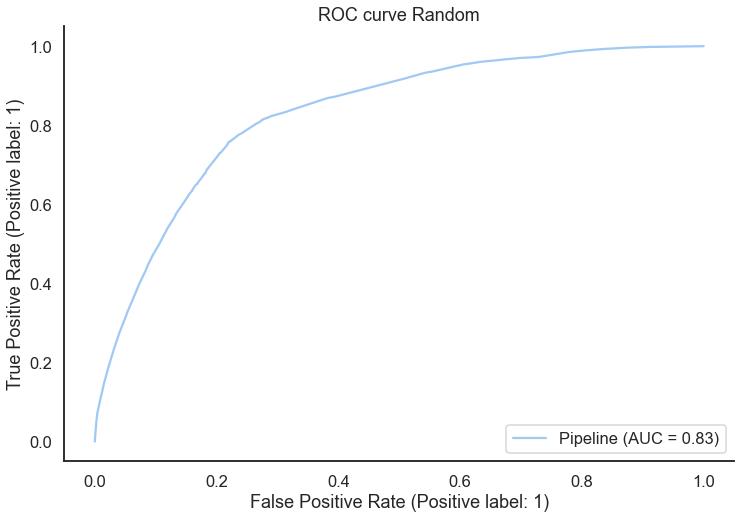

<Figure size 1280x960 with 0 Axes>

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
figure(figsize=(16, 12), dpi=80)

model_displays = RocCurveDisplay.from_estimator(
    model, X_test_rnd, y_test_rnd, ax=ax
)
_ = ax.set_title("ROC curve Random")

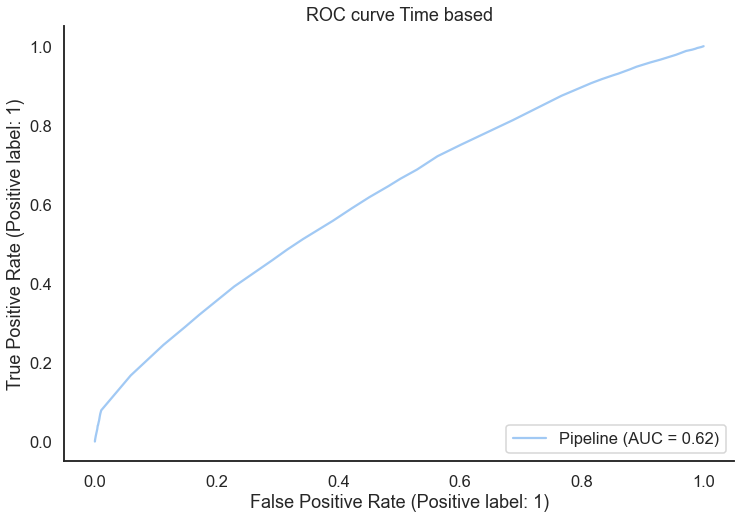

<Figure size 1280x960 with 0 Axes>

In [96]:
fig, ax = plt.subplots()
figure(figsize=(16, 12), dpi=80)

model_displays = RocCurveDisplay.from_estimator(
    model, X_test_ts, y_test_ts, ax=ax
)
_ = ax.set_title("ROC curve Time based")